In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
image_df = pd.read_csv('/ssd-data/MRKR_dataset/MRKR_clinical_data_tables/MRKR_image_metadata.csv')
pain_df = pd.read_csv('/ssd-data/MRKR_dataset/MRKR_clinical_data_tables/MRKR_pain.csv')
icd_df = pd.read_csv('/ssd-data/MRKR_dataset/MRKR_clinical_data_tables/MRKR_ICD.csv')
demo_df = pd.read_csv('/ssd-data/MRKR_dataset/MRKR_clinical_data_tables/MRKR_demographics.csv')

In [3]:
image_df = image_df.rename(columns={'StudyDate_anon':'date_anon'})


In [4]:
remove_df = icd_df[(icd_df.joint_infection==1) | (icd_df.trauma_lower_extremity==1) | (icd_df.knee_osteomyelitis==1)][['empi_anon','date_anon']].drop_duplicates().reset_index(drop=True)


In [5]:
remove_df.shape

(125113, 2)

In [6]:
# Ensure date_anon columns in both datasets are in datetime format
image_df['date_anon'] = pd.to_datetime(image_df['date_anon'])
remove_df['date_anon'] = pd.to_datetime(remove_df['date_anon'])

# Sort both DataFrames by patient ID and date for pd.merge_asof to work
image_df = image_df.sort_values(by=['empi_anon','date_anon'])
remove_df = remove_df.sort_values(by=['empi_anon','date_anon'])


In [7]:
# Perform a merge on 'empi_anon' and allow a condition for date difference
merged_df = pd.merge(image_df, remove_df, on='empi_anon', suffixes=('_main', '_remove'))

# Filter the merged DataFrame where the date difference is within 90 days
merged_df['date_diff'] = (merged_df['date_anon_main'] - merged_df['date_anon_remove']).abs()

# Keep only rows where the date difference is within 90 days
matches_within_30_days = merged_df[merged_df['date_diff'] <= pd.Timedelta(days=90)]

# Drop the date_diff column if it's not needed
matches_within_30_days = matches_within_30_days.drop(columns=['date_diff'])

In [8]:
image_df.shape

(503261, 19)

In [9]:
image_df = image_df[~image_df.dicom_path.isin(matches_within_30_days.dicom_path.tolist())].reset_index(drop=True)

In [10]:
image_df.shape

(383450, 19)

In [11]:
autoimmune_patients = icd_df[(icd_df.autoimmune==1)].empi_anon.unique().tolist()

In [12]:
image_df = image_df[~image_df.empi_anon.isin(autoimmune_patients)]

In [13]:
selected_df = image_df[(image_df.laterality=="B") & (image_df.weight_bearing==1) & (image_df.view_position=="F") & (image_df.age_at_exam<90)].reset_index(drop=True)


In [14]:
right_df = selected_df.copy()
left_df = selected_df.copy()

In [15]:
right_df = right_df[(right_df.arthroplasty=="0") | (right_df.arthroplasty=="L")]
left_df = left_df[(left_df.arthroplasty=="0") | (left_df.arthroplasty=="R")]

In [16]:
pain_df.laterality.value_counts(dropna=False)

laterality
NaN    4724556
R        96492
L        87153
B        62668
Name: count, dtype: int64

In [17]:
right_pain_df = pain_df[(pain_df.laterality=="R") | (pain_df.laterality=="B")]
left_pain_df = pain_df[(pain_df.laterality=="L") | (pain_df.laterality=="B")]

In [18]:
right_df = right_df.rename(columns={'StudyDate_anon':'date_anon'})
left_df = left_df.rename(columns={'StudyDate_anon':'date_anon'})

In [19]:
right_df['date_anon'] = pd.to_datetime(right_df['date_anon'])
right_pain_df['date_anon'] = pd.to_datetime(right_pain_df['date_anon'])

left_df['date_anon'] = pd.to_datetime(left_df['date_anon'])
left_pain_df['date_anon'] = pd.to_datetime(left_pain_df['date_anon'])

/tmp/ipykernel_3042315/2115231548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_pain_df['date_anon'] = pd.to_datetime(right_pain_df['date_anon'])
/tmp/ipykernel_3042315/2115231548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_pain_df['date_anon'] = pd.to_datetime(left_pain_df['date_anon'])


In [20]:
right_df = right_df.sort_values(by=['date_anon'])
left_df = left_df.sort_values(by=['date_anon'])

right_pain_df = right_pain_df.sort_values(by=['date_anon'])
left_pain_df = left_pain_df.sort_values(by=['date_anon'])

In [21]:
right_merged_df = pd.merge_asof(right_df, right_pain_df[['empi_anon','pain_score','date_anon']], on='date_anon', by='empi_anon', tolerance=pd.Timedelta(days=3), direction='nearest')

left_merged_df = pd.merge_asof(left_df, left_pain_df[['empi_anon','pain_score','date_anon']], on='date_anon', by='empi_anon', tolerance=pd.Timedelta(days=3), direction='nearest')



In [22]:
right_merged_df.pain_score.value_counts(dropna=False)

pain_score
NaN     36377
5.0      2660
8.0      2564
7.0      2236
6.0      1836
4.0      1801
3.0      1363
10.0     1304
2.0      1010
9.0       982
0.0       603
1.0       494
Name: count, dtype: int64

In [23]:
left_merged_df.pain_score.value_counts(dropna=False)

pain_score
NaN     37710
5.0      2542
8.0      2477
7.0      2212
4.0      1786
6.0      1781
3.0      1337
10.0     1204
9.0       974
2.0       958
0.0       583
1.0       454
Name: count, dtype: int64

In [24]:
right_final_df = right_merged_df.dropna(subset=['pain_score'])
left_final_df = left_merged_df.dropna(subset=['pain_score'])

In [25]:
right_final_df = right_final_df.rename(columns={'R_KLG_inference':'KLG_inference'})
left_final_df = left_final_df.rename(columns={'L_KLG_inference':'KLG_inference'})


In [26]:
right_final_df['laterality']="R"
left_final_df['laterality']="L"

In [27]:
data_df = pd.concat([right_final_df, left_final_df]).reset_index(drop=True)

In [28]:
image_df[(image_df.laterality=="B") & (image_df.view_position=="F")  & (image_df.weight_bearing==1) & (image_df.arthroplasty=="0")].R_KLG_inference.value_counts(dropna=False)


R_KLG_inference
2.0    17472
0.0    13347
3.0     9305
4.0     5176
1.0     2539
NaN       84
Name: count, dtype: int64

In [29]:
data_df.shape

(33161, 21)

In [30]:
data_df.KLG_inference.value_counts(dropna=False)

KLG_inference
2.0    11652
3.0     8505
0.0     6684
4.0     4628
1.0     1622
NaN       70
Name: count, dtype: int64

In [31]:
data_df = data_df.dropna(subset=['KLG_inference'])

In [32]:
data_df = pd.merge(data_df, demo_df[['empi_anon','sex','race']])


<Axes: >

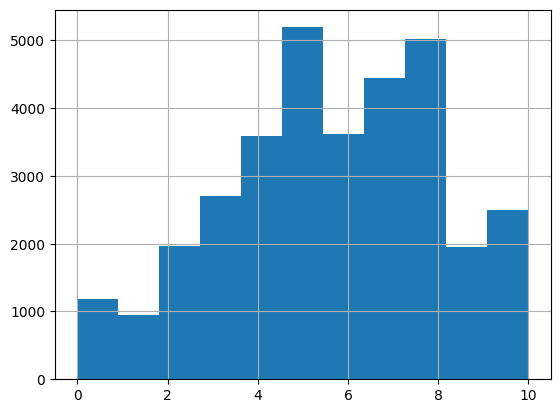

In [33]:
data_df.pain_score.hist(bins=11)

<Axes: >

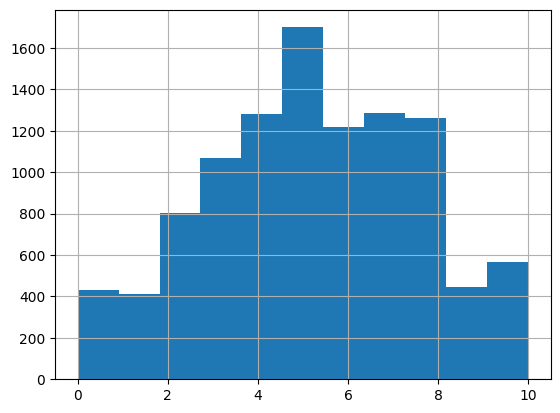

In [34]:
data_df[data_df.sex=="Male"].pain_score.hist(bins=11)

<Axes: >

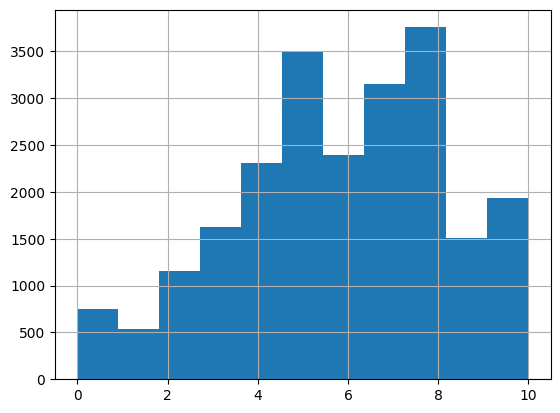

In [35]:
data_df[data_df.sex=="Female"].pain_score.hist(bins=11)

<Axes: >

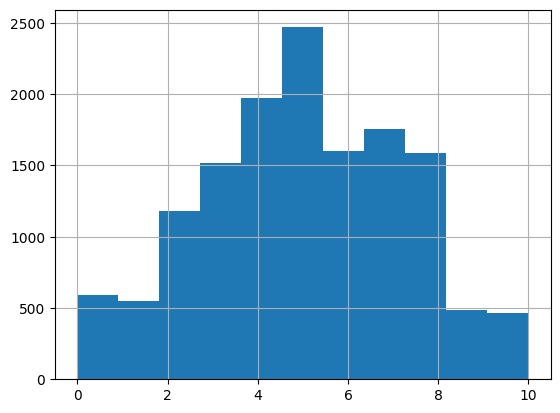

In [36]:
data_df[data_df.race=="Caucasian or White"].pain_score.hist(bins=11)

<Axes: >

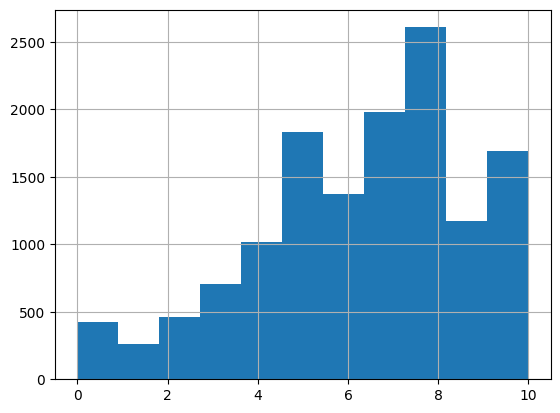

In [37]:
data_df[data_df.race=="African American or Black"].pain_score.hist(bins=11)